In [1]:
%load_ext autoreload
%autoreload 2

import inspect

import os
import sys
import pickle
import torch
from torchvision import transforms
from tqdm.autonotebook import tqdm
import json
import argparse
from recursion_schemes.recursion_schemes import ana_greedy, ana_beam
from bayesian_agents.joint_rsa_oldmodel import RSA
from rsa_utils.numpy_functions import uniform_vector, make_initial_prior
from PIL import Image

file_dir = os.path.dirname(os.path.abspath('/home/vu48pok/Dokumente/Projekte/diversity/diversity_fresh/code/rsa/predict_rsa.ipynb'))
root_dir = os.path.abspath(os.path.join(file_dir, os.pardir))
sys.path.append(root_dir)

from utilities.data_utils import get_coco_captions, get_karpathy_splits, refcoco_splits, refcocoplus_splits, filename_from_id
from utilities.build_vocab import Vocabulary, char_vocab

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

[nltk_data] Downloading package punkt to /home/vu48pok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
def get_img_dir(img_id, image_dir):

    img_path = os.path.join(
        image_dir, 'val2014/',
        filename_from_id(img_id, prefix='COCO_val2014_')
        )
    return img_path


def get_images_from_cluster(i, image_cluster, transform, image_dir):

    images = []
    # set up list containing data for all images in the current cluster
    for j in range(len(image_cluster[i])):

        image_id = image_cluster[i][j]
        img_dir = get_img_dir(image_id, image_dir)
        image = Image.open(img_dir).convert('RGB')
        image_tensor = transform(image).to(device).unsqueeze(0)

        images.append(image_tensor)

    return images


def rsa_decode_cluster(
    index, speaker_model, rat, image_cluster,
    transform, image_dir, device=device, dstrategy='greedy'
        ):

    image_tensors = get_images_from_cluster(
        index, image_cluster, transform, image_dir
        )

    # the model starts of assuming it's equally likely
    # any image is the intended referent
    initial_image_prior = uniform_vector(len(image_tensors))
    initial_rationality_prior = uniform_vector(1)
    initial_speaker_prior = uniform_vector(1)
    initial_world_prior = make_initial_prior(
        initial_image_prior, initial_rationality_prior, initial_speaker_prior)

    # set the possible images and rationalities
    speaker_model.initial_speakers.set_features(
        images=image_tensors, tf=False, rationalities=rat)

    if dstrategy=='beam':
        caption, history = ana_beam(
            rsa=speaker_model, initial_world_prior=initial_world_prior, speaker_rationality=0, target=0, speaker=0, 
            pass_prior=False, listener_rationality=1.0, depth=0, start_from=[],
            beam_width=5, cut_rate=1, decay_rate=0.0, beam_decay=0, no_progress_bar=True, end_token='$'
        )
    else:
        caption = ana_greedy(
            speaker_model, target=0, depth=0, speaker_rationality=0,
            speaker=0, start_from=list(""),
            start_token='^', end_token='$',
            initial_world_prior=initial_world_prior, no_progress_bar=True
        )
        history = []

    out = ({
        'image_id': int(image_cluster[index][0]),
        'caption': caption[0][0]  # [9:-5]  # slicing to remove <start> / <end>
    }, history)

    return out


def main(args):
    
    args.vocab_path = '/home/vu48pok/Dokumente/Projekte/diversity/NLGDiversity/code/data/vocab/coco_vocab.pkl'
    model_dir = '/mnt/local/Diversity Models/trained_vanilla_models/'
    #encoder_path = model_dir + 'coco_captions-word-listener-encoder-final.ckpt'
    #decoder_path = model_dir + 'coco_captions-word-listener-decoder-final.ckpt'
    encoder_path = '/home/vu48pok/Dokumente/Projekte/diversity/09-diversity-pragmatics/code/models/vanilla/trained_models/coco-char-encoder-final.ckpt'
    decoder_path = '/home/vu48pok/Dokumente/Projekte/diversity/09-diversity-pragmatics/code/models/vanilla/trained_models/coco-char-decoder-final.ckpt'    
    
    #########
    # SETUP #
    #########

    print('----------------Setup----------------')

    # load vocab
    #with open(args.vocab_path, 'rb') as f:
    #    vocab = pickle.load(f)
    vocab = char_vocab()
    
    # define image transformation parameters
    transform = transforms.Compose([
        transforms.Resize((args.crop_size, args.crop_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                             (0.229, 0.224, 0.225))
    ])

    # get cluster loader
    with open(args.cluster_path, 'rb') as f:
        image_clusters = pickle.load(f)

    # initialize speakers using the model parameters
    speaker_model = RSA(seg_type='char', vocabulary=vocab)
    #speaker_model.initialize_speakers(model_path=args.model_path)
    speaker_model.initialize_speakers(encoder_path=encoder_path, decoder_path=decoder_path)
    
    # the rationality of the S1
    rat = [args.speaker_rat]

    #####################
    # GENERATE CAPTIONS #
    #####################

    print('----------------Decoding----------------')

    caps = []

    for i in tqdm(range(len(image_clusters))):

        c = rsa_decode_cluster(
            i, speaker_model, rat, image_clusters, transform, args.image_dir,
            dstrategy='beam'
            )
        history = c[1]
        c = c[0]
        print(str(i) + ' ' + str(c))
        caps.append(c)
        return(history)

    #########################
    # write outputs to file #
    #########################

    print('----------------Saving File----------------')

    if not os.path.exists(args.out_dir):
        os.mkdir(args.out_dir)
        print('created dir', args.out_dir)

    file_path = os.path.join(
        args.out_dir,
        '{m_name}_{d_name}_rat{rat}.json'.format(
                m_name='adaptiveg_rsa_char',
                d_name='greedy',
                rat=str(args.speaker_rat).replace('.', '-')
            ).lower()
        )
#    with open(file_path, 'w') as outfile:
#        json.dump(caps, outfile)

    print('saved file to', file_path)

In [3]:
if __name__ == "__main__":

    parser = argparse.ArgumentParser()

    parser.add_argument('-f', default='self',
                        help='To make it runnable in jupyter')
    parser.add_argument('--model_path', type=str,
                        default='/home/vu48pok/Dokumente/Projekte/diversity/diversity_fresh/data/models/speaker/adaptive-49.pkl',
                        help='path for trained models')
    parser.add_argument('--crop_size', type=int, default=224,
                        help='size for randomly cropping images')
    parser.add_argument('--vocab_path', type=str,
                        default='/home/vu48pok/Dokumente/Projekte/diversity/diversity_fresh/data/models/speaker/speaker2014_c.pkl',
                        help='path for vocabulary wrapper')
    parser.add_argument('--image_dir', type=str,
                        default='/home/vu48pok/.data/compling/data/corpora/external/MSCOCO/COCO/',
                        help='directory for resized training images')
    parser.add_argument('--out_dir', type=str,
                        default='/home/vu48pok/Dokumente/Projekte/diversity/diversity_fresh/data/models/speaker/',
                        help='output dir')
    parser.add_argument('--speaker_rat', type=float, default=5.0,
                        help='speaker rationality')
    parser.add_argument('--splits_path', type=str,
                        default='/home/vu48pok/Dokumente/Projekte/diversity/diversity_fresh/data/karpathy_splits/',
                        help='path to splits')
    parser.add_argument('--captions_path', type=str,
                        default='/home/vu48pok/.data/compling/data/corpora/external/MSCOCO/COCO/',
                        help='path to captions')
    parser.add_argument('--cluster_path', type=str,
                        default='/home/vu48pok/Dokumente/Projekte/diversity/diversity_fresh/data/image_clusters_val.pkl',
                        help='path to image cluster file')
    parser.add_argument('--split_name', type=str, default='val',
                        help='test or val split')

    args = parser.parse_args()

    print('----------------Settings----------------')
    print(args)

    main(args)

----------------Settings----------------
Namespace(captions_path='/home/vu48pok/.data/compling/data/corpora/external/MSCOCO/COCO/', cluster_path='/home/vu48pok/Dokumente/Projekte/diversity/diversity_fresh/data/image_clusters_val.pkl', crop_size=224, f='/home/vu48pok/.local/share/jupyter/runtime/kernel-b558ee35-f4bd-4442-aa42-c2d7cbd88374.json', image_dir='/home/vu48pok/.data/compling/data/corpora/external/MSCOCO/COCO/', model_path='/home/vu48pok/Dokumente/Projekte/diversity/diversity_fresh/data/models/speaker/adaptive-49.pkl', out_dir='/home/vu48pok/Dokumente/Projekte/diversity/diversity_fresh/data/models/speaker/', speaker_rat=5.0, split_name='val', splits_path='/home/vu48pok/Dokumente/Projekte/diversity/diversity_fresh/data/karpathy_splits/', vocab_path='/home/vu48pok/Dokumente/Projekte/diversity/diversity_fresh/data/models/speaker/speaker2014_c.pkl')
----------------Setup----------------
----------------Decoding----------------


/home/vu48pok/Dokumente/Projekte/diversity/09-diversity-pragmatics/code/rsa/rsa_utils/sample.py:10: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(x, volatile=volatile)


Hello this is beam search
['^', 'a', ' ', 'l', 'i', 'v', 'i', 'n', 'g', ' ', 'r', 'o', 'o', 'm', ' ', 'f', 'i', 'l', 'l', 'e', 'd', ' ', 'w', 'i', 't', 'h', ' ', 'f', 'u', 'r', 'n', 'i', 't', 'u', 'r', 'e', ' ', 'a', 'n', 'd', ' ', 'c', 'h', 'a', 'i', 'r', 's', '$']
0 {'image_id': 133, 'caption': '^a living room filled with furniture and chairs$'}


In [4]:
history = main(args)

----------------Setup----------------

----------------Decoding----------------


Hello this is beam search
['^', 'a', ' ', 'l', 'i', 'v', 'i', 'n', 'g', ' ', 'r', 'o', 'o', 'm', ' ', 'f', 'i', 'l', 'l', 'e', 'd', ' ', 'w', 'i', 't', 'h', ' ', 'f', 'u', 'r', 'n', 'i', 't', 'u', 'r', 'e', ' ', 'a', 'n', 'd', ' ', 'c', 'h', 'a', 'i', 'r', 's', '$']
0 {'image_id': 133, 'caption': '^a living room filled with furniture and chairs$'}


In [13]:
import networkx as nx
import matplotlib.pyplot as plt
import pydot
from IPython.display import Image, display
from numpy import exp

In [48]:
def view_pydot(pdot):
    plt = Image(pdot.create_png())
    display(plt)

def graph_from_history(history, caption=None, start=None, end=None, root_name='ROOT'):
    
    start = 0 if not start else start
    end = len(history) if not end else end
    
    graph = pydot.Dot(graph_type='graph')
    
    for timestep in range(len(history))[start:end]:
        for beam in history[timestep]:

            current_s = beam[0]
            current_prob = round(exp(beam[2]), 5)
            node = ''.join(current_s).replace(' ', '_')
            char = node[-1]
            parent = node[:-1] if node[:-1] != '' else root_name

            graph.add_node(pydot.Node(node, label=char))
            
            if caption:
                c = 'green' if node in caption else 'black'
            else:
                c = 'black'
                
            edge = pydot.Edge(parent, node, label=current_prob, color=c)
            graph.add_edge(edge)
            
    return graph            


def nx_graph_from_history(history):

    #G = nx.Graph()
    G = nx.DiGraph()
    for timestep in range(len(history)):
        for beam in history[timestep]:

            current_s = beam[0]
            current_prob = beam[2]
            node = ''.join(current_s).replace(' ', '_')
            char = node[-1]
            parent = node[:-1] if len(node[:-1]) > 0 else 'ROOT'

            G.add_node(node, nh=char, char=char, prob=current_prob, sent=node)
            G.add_edge(parent, node, prob=current_prob)#, sent=node, char=char)
    
    return G

In [49]:
caption = '^a living room filled with furniture and chairs$'.replace(' ', '_')
graph = graph_from_history(history, caption=caption)

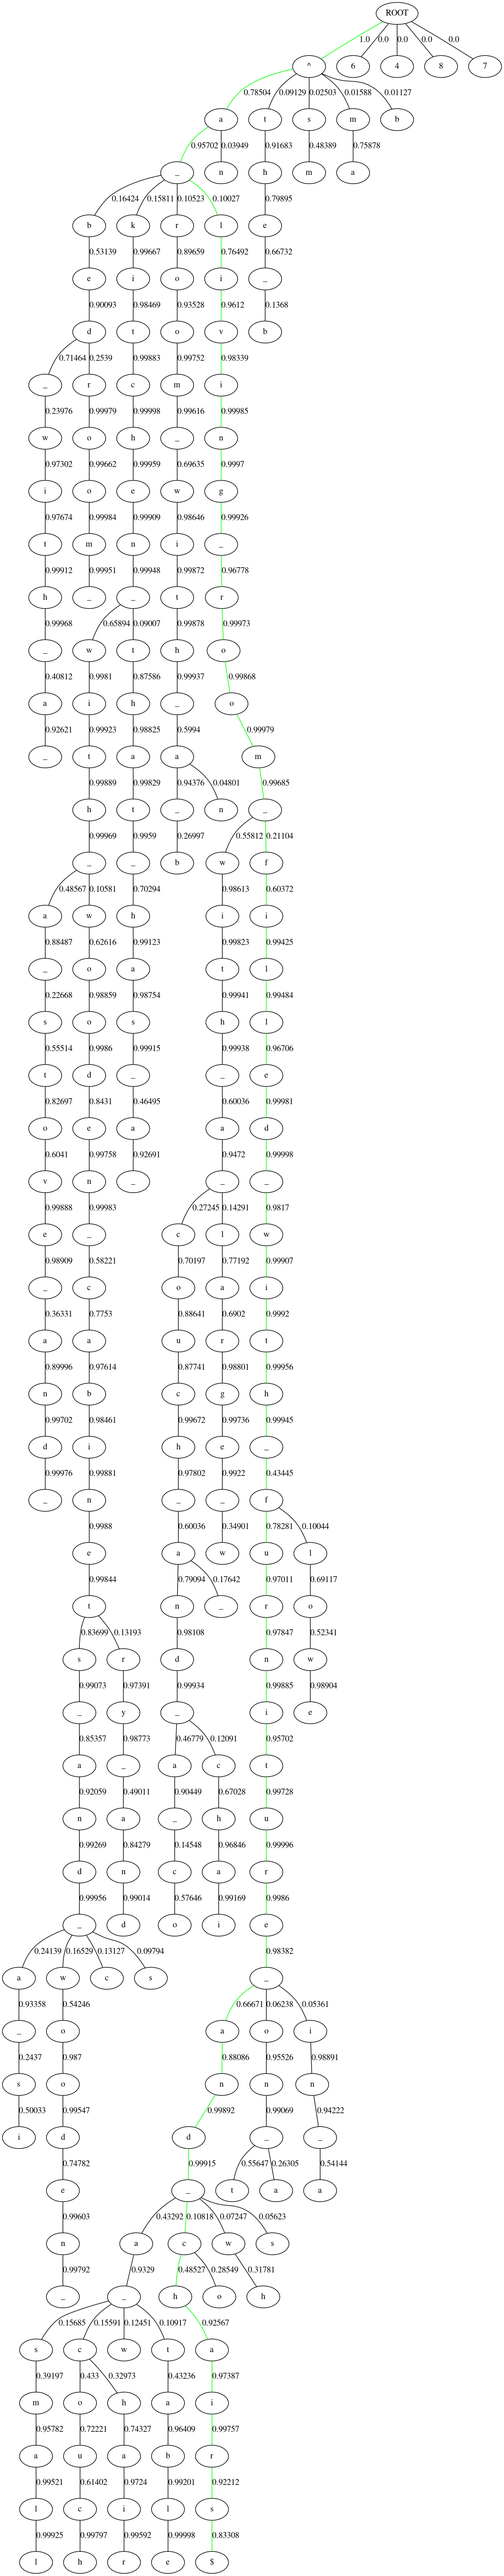

In [51]:
view_pydot(graph)
# graph.write_png('beam_graph.png')